In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path,filter='fully_trusted')
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()

In [6]:
np.random.seed(42)
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [7]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [9]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [10]:
housing = strat_train_set.copy()

In [11]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [14]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [16]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [17]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [18]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 88983.14806384 305351.35385026 153334.71183453 184302.55162102
 246840.18988841]


In [19]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

np.float64(69050.56219504567)

In [20]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

np.float64(49905.329442715316)

In [21]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [22]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

np.float64(0.0)

In [23]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [24]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [71177.6601991  69770.07865373 64770.5639395  68536.60203993
 67057.08155801 68847.12456973 70977.38255647 69208.86346929
 67187.87131535 73280.38732407]
Mean: 69081.361562518
Standard deviation: 2296.288087393378


In [25]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [72229.03469752 65318.2240289  67706.39604745 69368.53738998
 66767.61061621 73003.75273869 70522.24414582 69440.77896541
 66930.32945876 70756.31946074]
Mean: 69204.32275494764
Standard deviation: 2372.070791055923


In [26]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

np.float64(18342.366362322846)

In [27]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51039.08053738 48741.94041426 45940.42771745 50501.41453432
 47387.7896427  49595.25845731 51625.68567717 48865.70709952
 47322.87631489 53301.08748462]
Mean: 49432.12678796127
Standard deviation: 2124.8587921578355


In [28]:

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)

Scores: [72229.03469752 65318.2240289  67706.39604745 69368.53738998
 66767.61061621 73003.75273869 70522.24414582 69440.77896541
 66930.32945876 70756.31946074]
Mean: 69204.32275494764
Standard deviation: 2372.070791055923


In [30]:
from sklearn.model_selection import GridSearchCV
param_grid = [
 {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
 {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
 ]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
 scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [32]:
forest_reg = RandomForestRegressor(max_features=6, n_estimators=30, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51291.24909772 48566.40587353 46366.24028525 51686.52528131
 48265.95439452 49655.023849   51413.48625669 49964.62954935
 48209.72560292 53089.04770231]
Mean: 49850.82878926046
Standard deviation: 1934.4505250059196


In [39]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'kernel': ['linear'], 'C': [0.01, 0.1, 1, 10, 100, 1000]},
    {'kernel': ['rbf'], 'C': [0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1]}  
]

svr = SVR()
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error',  return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100, 1000],
                          'kernel': ['linear']},
                         {'C': [0.01, 0.1, 1, 10, 100, 1000],
                          'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['rbf']}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [34]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear", C=1000)
svm_reg.fit(housing_prepared, housing_labels)

svg_scores = cross_val_score(svm_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
svg_rmse_scores = np.sqrt(-svg_scores)
display_scores(svg_rmse_scores)

Scores: [73457.09473095 67622.09968113 67146.00780645 71266.72217794
 67583.28529778 74584.1763451  72114.57455061 70974.57229765
 68398.89429407 71738.40622709]
Mean: 70488.58334087554
Standard deviation: 2506.6038520816137


In [37]:
import time

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(max_features=6, n_estimators=30, random_state=42),
    "Support Vector Regressor": SVR(kernel="linear", C=1000)
}


for model_name, model in models.items():
    start_time = time.time()
    model.fit(housing_prepared, housing_labels)
    fit_time = time.time() - start_time

    start_time = time.time()
    scores = cross_val_score(model, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
    cross_val_time = time.time() - start_time

    rmse_scores = np.sqrt(-scores)

    print(f"\nModel: {model_name}")
    display_scores(rmse_scores)
    print(f"Time taken to fit the model: {fit_time:.4f} seconds")
    print(f"Time taken for cross-validation: {cross_val_time:.4f} seconds")


Model: Linear Regression
Scores: [72229.03469752 65318.2240289  67706.39604745 69368.53738998
 66767.61061621 73003.75273869 70522.24414582 69440.77896541
 66930.32945876 70756.31946074]
Mean: 69204.32275494764
Standard deviation: 2372.070791055923
Time taken to fit the model: 0.0120 seconds
Time taken for cross-validation: 0.0993 seconds

Model: Decision Tree
Scores: [71431.61230405 69435.20687777 64282.27106586 69607.12277347
 68628.42637805 70206.58699832 71532.96272819 70660.48516456
 66995.30198355 71501.74640685]
Mean: 69428.17226806871
Standard deviation: 2189.497028929263
Time taken to fit the model: 0.1733 seconds
Time taken for cross-validation: 1.5933 seconds

Model: Random Forest
Scores: [51291.24909772 48566.40587353 46366.24028525 51686.52528131
 48265.95439452 49655.023849   51413.48625669 49964.62954935
 48209.72560292 53089.04770231]
Mean: 49850.82878926046
Standard deviation: 1934.4505250059196
Time taken to fit the model: 1.7034 seconds
Time taken for cross-validati

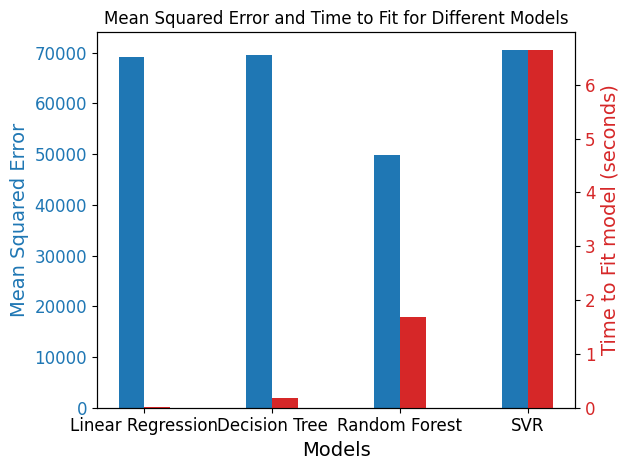

In [38]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(max_features=6, n_estimators=30, random_state=42),
    "SVR": SVR(kernel="linear", C=1000)
}
mse_results = []
fit_times = []
for model_name, model in models.items():
    
    start_time = time.time()
    model.fit(housing_prepared, housing_labels)
    fit_time = time.time() - start_time

    start_time = time.time()
    scores = cross_val_score(model, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
    cross_val_time = time.time() - start_time

    rmse_scores = np.sqrt(-scores)
    mse_results.append(rmse_scores.mean())
    fit_times.append(fit_time)

x = np.arange(len(models))
width = 0.20 
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Models')
ax1.set_ylabel('Mean Squared Error', color=color)
bars1 = ax1.bar(x - width/2, mse_results, width, label='MSE', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Time to Fit model (seconds)', color=color)
bars2 = ax2.bar(x + width/2, fit_times, width, label='Fit Time', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_xticks(x)
ax1.set_xticklabels(models.keys())

plt.title('Mean Squared Error and Time to Fit for Different Models')
fig.tight_layout() 
plt.show()